# Gaussian Process Particle Filter

* Image-based localization using Gaussian processes. M Lopez-Antequera, N Petkov, J Gonzalez-Jimenez. 2016.
* City-scale continuous visual localization. M Lopez-Antequera, N Petkov, J Gonzalez-Jimenez. 2017.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import geometry2
from utils import load_utils
from utils.particleFilter import gppf, gppf_map
import time, sys

/home/alberto/work/AppearanceSeqMCL/utils/transformations.py:1926: UserWarning: No module named 'utils._transformations'
  warnings.warn(str(err))


# Data

In [2]:
PATH_MAP = "./data/map.json"
PATH_SEQ = "./data/seq1_night1.json"

#FEAT_SUFFIX = '-NetVLAD_layer.h5' # Not available
FEAT_SUFFIX = '-ImRet_R101gw.h5'

Loaded poses: 4111 feats: 4111 odoms: 0
Loaded poses: 1911 feats: 1911 odoms: 1911


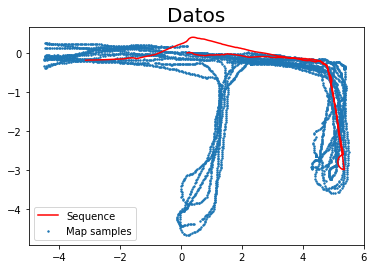

In [3]:
# Map
seq_dict_map = load_utils.load_sequence(PATH_MAP, FEAT_SUFFIX)
poses_map, feats_map = seq_dict_map['poses'], seq_dict_map['feats']

# Select some inds for evaluation
seq_dict_ev = load_utils.load_sequence(PATH_SEQ, FEAT_SUFFIX)
assert 'odoms' in seq_dict_ev.keys() and 'noise' in seq_dict_ev.keys()
ev_inds = np.arange(0, 560)
poses_seq, feats_seq, odoms_seq = seq_dict_ev['poses'][ev_inds], seq_dict_ev['feats'][ev_inds], seq_dict_ev['odoms'][ev_inds]

plt.title('Datos', fontsize=20)
plt.scatter(poses_map.t()[:, 0],  poses_map.t()[:, 1],  s=2, label='Map samples')
plt.plot(poses_seq.t()[:, 0],  poses_seq.t()[:, 1], 'r', label='Sequence')
plt.legend(loc=3)
plt.show()

# Map

In [4]:
# Set the map
dense_map = gppf_map.GPPFMap(poses_map, feats_map, sod_neighbors=10)

# Paticle Filter (perfect initialization)

In [5]:
# Dar el número de partículas
pf = gppf.GaussianProcessParticleFilter(100, dense_map)
pf.verbose = True
# Ejecutar para las odometrías, las observaciones (son 1) y las poses dadas
pf.run(odoms_seq, feats_seq, gt_poses=poses_seq, step_incr=2, step_plot=10)

PERFECT INITIALIZATION!
Step 10 Pose error  0.04 0.49 (m, º) ATE 0.01
Step 20 Pose error  0.02 0.66 (m, º) ATE 0.01
Step 30 Pose error  0.05 1.44 (m, º) ATE 0.01
Step 40 Pose error  0.11 0.76 (m, º) ATE 0.02
Step 50 Pose error  0.14 1.14 (m, º) ATE 0.03
Step 60 Pose error  0.11 2.02 (m, º) ATE 0.03
Step 70 Pose error  0.12 2.88 (m, º) ATE 0.03
Step 80 Pose error  0.10 2.70 (m, º) ATE 0.03
Step 90 Pose error  0.07 2.76 (m, º) ATE 0.03
Step 100 Pose error  0.05 3.86 (m, º) ATE 0.03
Step 110 Pose error  0.02 4.00 (m, º) ATE 0.03
Step 120 Pose error  0.05 4.15 (m, º) ATE 0.03
Step 130 Pose error  0.18 5.90 (m, º) ATE 0.03
Step 140 Pose error  0.30 5.34 (m, º) ATE 0.04
	Resampling step 144
Step 150 Pose error  0.28 5.44 (m, º) ATE 0.04
Step 160 Pose error  0.28 6.29 (m, º) ATE 0.05
Step 170 Pose error  0.26 5.20 (m, º) ATE 0.05
Step 180 Pose error  0.25 4.34 (m, º) ATE 0.05
	Resampling step 182
Step 190 Pose error  0.24 4.53 (m, º) ATE 0.05
Step 200 Pose error  0.25 5.69 (m, º) ATE 0.06
Ste

## Plot

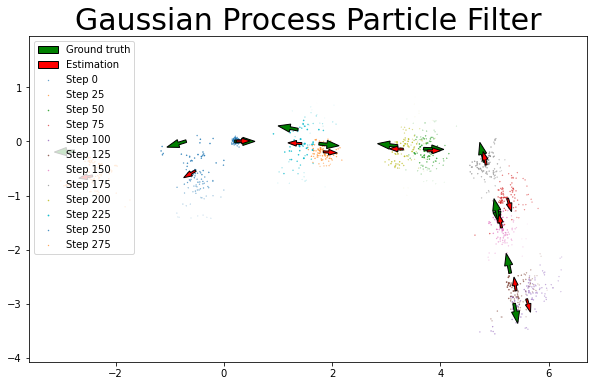

In [6]:
f, ax = plt.subplots(figsize=(10, 6))
plt.title('Gaussian Process Particle Filter', fontsize=30)
for i in range(0, len(pf.historial), 25):
    minx = poses_map.t()[:, 0].min()
    miny = poses_map.t()[:, 1].min()
    maxx = poses_map.t()[:, 0].max()
    maxy = poses_map.t()[:, 1].max()
    
    plt.xlim(minx, maxx)
    plt.ylim(miny, maxy)
    
    plt.scatter(pf.historial[i][:, 0], 
                pf.historial[i][:, 1], 
                s=(pf.historial[i][:, 2]**2)*1000, label='Step %d'%i)
    
    str_gt = 'Ground truth' if i == 0 else None
    gt = pf.gt_poses[i*pf.step_incr]
    ang = gt.R().as_euler('xyz')[-1]
    plt.arrow(gt.t()[0], 
              gt.t()[1], 
              np.cos(ang) * 0.15, 
              np.sin(ang) * 0.15,
              facecolor='g',
              width=0.05, label=str_gt)
    
    str_estim = 'Estimation' if i == 0 else None
    estimation = pf.result[i][0]
    ang = estimation.R().as_euler('xyz')[-1]
    plt.arrow(estimation.t()[0], 
              estimation.t()[1], 
              np.cos(ang) * 0.1, 
              np.sin(ang) * 0.1,
              facecolor='r',
              width=0.035, label=str_estim)
        

plt.axis('equal')
plt.legend()
plt.show()

# Paticle Filter (random initialization)

In [7]:
# Dar el número de partículas
pf = gppf.GaussianProcessParticleFilter(250, dense_map)
pf.verbose = True
# Ejecutar para las odometrías, las observaciones (son 1) y las poses dadas
pf.run(odoms_seq, feats_seq, gt_poses=poses_seq, init='random', step_incr=2, step_plot=10)

RANDOM INITIALIZATION!
Step 10 Pose error  0.95 5.49 (m, º) ATE 0.30
	Resampling step 18
Step 20 Pose error  0.23 19.59 (m, º) ATE 0.22
Step 30 Pose error  0.41 12.72 (m, º) ATE 0.19
	Resampling step 34
Step 40 Pose error  0.23 11.90 (m, º) ATE 0.17
Step 50 Pose error  0.29 13.31 (m, º) ATE 0.16
	Resampling step 58
Step 60 Pose error  0.35 12.39 (m, º) ATE 0.15
Step 70 Pose error  0.44 10.68 (m, º) ATE 0.15
Step 80 Pose error  0.55 7.79 (m, º) ATE 0.15
Step 90 Pose error  0.64 5.81 (m, º) ATE 0.16
Step 100 Pose error  0.74 4.71 (m, º) ATE 0.17
	Resampling step 102
Step 110 Pose error  0.76 3.42 (m, º) ATE 0.18
Step 120 Pose error  0.71 3.05 (m, º) ATE 0.18
Step 130 Pose error  0.68 4.66 (m, º) ATE 0.18
Step 140 Pose error  0.57 4.24 (m, º) ATE 0.18
Step 150 Pose error  0.52 4.96 (m, º) ATE 0.18
Step 160 Pose error  0.50 6.37 (m, º) ATE 0.18
Step 170 Pose error  0.42 5.70 (m, º) ATE 0.18
Step 180 Pose error  0.36 5.32 (m, º) ATE 0.18
	Resampling step 182
Step 190 Pose error  0.32 6.57 (

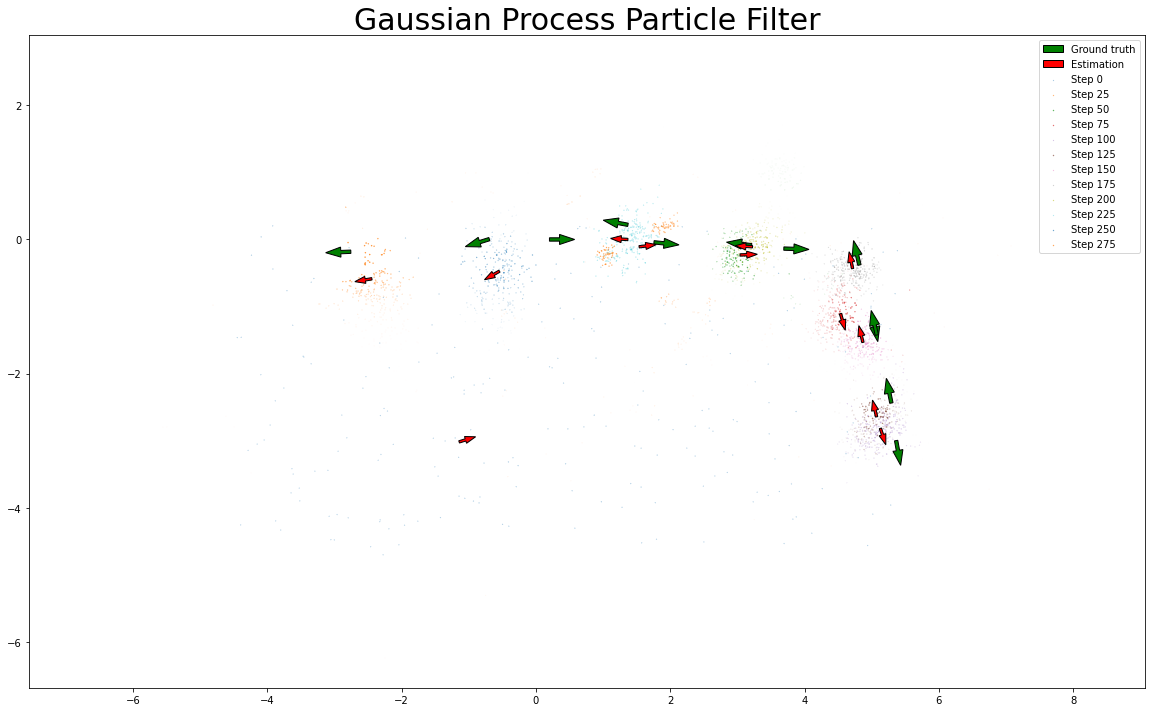

In [8]:
f, ax = plt.subplots(figsize=(20, 12))
plt.title('Gaussian Process Particle Filter', fontsize=30)
for i in range(0, len(pf.historial), 25):
    minx = poses_map.t()[:, 0].min()
    miny = poses_map.t()[:, 1].min()
    maxx = poses_map.t()[:, 0].max()
    maxy = poses_map.t()[:, 1].max()
    
    plt.xlim(minx, maxx)
    plt.ylim(miny, maxy)
    
    plt.scatter(pf.historial[i][:, 0], 
                pf.historial[i][:, 1], 
                s=(pf.historial[i][:, 2]**2)*1000, label='Step %d'%i)
    
    str_gt = 'Ground truth' if i == 0 else None
    gt = pf.gt_poses[i*pf.step_incr]
    ang = gt.R().as_euler('xyz')[-1]
    plt.arrow(gt.t()[0], 
              gt.t()[1], 
              np.cos(ang) * 0.15, 
              np.sin(ang) * 0.15,
              facecolor='g',
              width=0.05, label=str_gt)
    
    str_estim = 'Estimation' if i == 0 else None
    estimation = pf.result[i][0]
    ang = estimation.R().as_euler('xyz')[-1]
    plt.arrow(estimation.t()[0], 
              estimation.t()[1], 
              np.cos(ang) * 0.1, 
              np.sin(ang) * 0.1,
              facecolor='r',
              width=0.035, label=str_estim)
        

plt.axis('equal')
plt.legend()
plt.show()